<h3>Importing Libraries</h3>

In [1]:
# Importing Libraries
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM, Dropout
from keras import optimizers
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc,accuracy_score
from itertools import cycle
from keras.models import load_model
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from keras.metrics import Precision, Recall

Using TensorFlow backend.


<h4>Importing Dataset</h4>

In [2]:
train_log= pd.read_csv('/Users/jyoti/OneDrive/DLFinal/Project2/norm.csv')

In [3]:
train_log.columns

Index(['enrollment_id', 'date', 'access', 'discussion', 'navigate',
       'page_close', 'problem', 'video', 'wiki', 'session', 'tot_time',
       'result'],
      dtype='object')

In [4]:
df1 = train_log["access"]

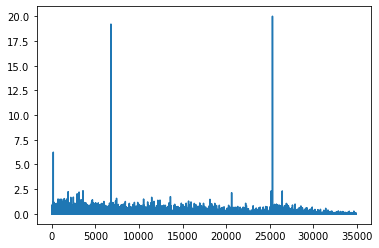

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

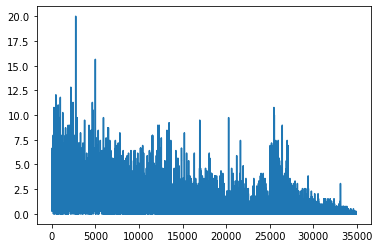

In [6]:
df2 = train_log["session"]
import matplotlib.pyplot as plt
plt.plot(df2)

In [7]:
train_num = 8000
test_num = 728

In [8]:
en_ids = train_log['enrollment_id'].unique()
print(en_ids.shape)

(8728,)


In [9]:
np.random.shuffle(en_ids)
en_ids

array([114181,  50551,  25326, ...,  34879, 160308,  87026])

In [10]:
tr_en_ids = en_ids[:train_num]
ts_en_ids = en_ids[train_num:]

In [11]:
(train_log[train_log['enrollment_id'].isin(ts_en_ids)]['result'].values.sum()/4)/728

0.6222527472527473

In [12]:
(train_log[train_log['enrollment_id'].isin(tr_en_ids)]['result'].values.sum()/4)/8000

0.64925

In [13]:
tr_en_ids.shape

(8000,)

In [14]:
ts_en_ids.shape

(728,)

<h4>Datagen Creation</h4>

In [15]:
import random
from sklearn import preprocessing
minmaxscaler_as = preprocessing.MinMaxScaler(feature_range = (0,1))
def datagen(batchsize = 32, mode = 'train'):
    counter = 0
    x, y = [],[]
    while True:
        if mode == 'train':
            idx = random.choice(tr_en_ids)
        else:
            idx =random.choice(ts_en_ids)
        temp = train_log[train_log['enrollment_id']==idx]
        row = []
        for i in range(temp.shape[0]):
            row.append(temp.iloc[i].values[2:-1]) #2:-1
        x.append(row)

        y.append(temp.iloc[0].values[-1])
        
        counter+=1
        if counter==batchsize:
           
            yield np.array(x),np.array(y)
            counter = 0
            x, y = [], [] 

In [16]:
tr_dg  = datagen(mode='train')
ts_dg = datagen(mode = 'test', batchsize=32)

<h4>Model Architecture</h4>

In [17]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, batch_input_shape=(32, 4,9),activation='tanh'))
regressorGRU.add(Dropout(0.2))
#Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, batch_input_shape=(32, 4,9),activation='tanh'))
regressorGRU.add(Dropout(0.2))
# # # Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, batch_input_shape=(32, 4,9), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (32, 4, 50)               9000      
_________________________________________________________________
dropout_1 (Dropout)          (32, 4, 50)               0         
_________________________________________________________________
gru_2 (GRU)                  (32, 4, 50)               15150     
_________________________________________________________________
dropout_2 (Dropout)          (32, 4, 50)               0         
_________________________________________________________________
gru_3 (GRU)                  (32, 4, 50)               15150     
_________________________________________________________________
dropout_3 (Dropout)          (32, 4, 50)               0         
_________________________________________________________________
gru_4 (GRU)                  (32, 50)                 

In [18]:
# Compiling the RNN

# regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy',Precision(), Recall()])
regressorGRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',Precision(), Recall()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<h4> Early Stopping and Check Points</h4>

In [19]:

# Create Checkpoint and Early Stopping
checkpoint = ModelCheckpoint("GRU_Adam_No_Regularisation.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto')

In [20]:
history = regressorGRU.fit(tr_dg, epochs=200,verbose=1, validation_data=ts_dg, steps_per_epoch=250, validation_steps=23,callbacks=[checkpoint,early])



Epoch 1/200
250/250 [==============================] - 42s 169ms/step - loss: 0.9067 - accuracy: 0.5439 - precision_1: 0.7238 - recall_1: 0.4905 - val_loss: 0.7766 - val_accuracy: 0.4348 - val_precision_1: 0.6552 - val_recall_1: 0.2426

Epoch 00001: val_accuracy improved from -inf to 0.43478, saving model to GRU_Adam_No_Regularisation.h5
Epoch 2/200
250/250 [==============================] - 30s 121ms/step - loss: 1.1177 - accuracy: 0.7155 - precision_1: 0.7901 - recall_1: 0.8065 - val_loss: 0.8724 - val_accuracy: 0.7745 - val_precision_1: 0.7822 - val_recall_1: 0.8957

Epoch 00002: val_accuracy improved from 0.43478 to 0.77446, saving model to GRU_Adam_No_Regularisation.h5
Epoch 3/200
250/250 [==============================] - 27s 110ms/step - loss: 1.1016 - accuracy: 0.6802 - precision_1: 0.7612 - recall_1: 0.7747 - val_loss: 0.5868 - val_accuracy: 0.7867 - val_precision_1: 0.7875 - val_recall_1: 0.9281cy: 0.7085 - - ETA: 8s - loss: 1.3012 - accuracy: 0.6656 - precision_1: 0.7703  -

<h4> Plots</h4>

dict_keys(['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'loss', 'accuracy', 'precision_1', 'recall_1'])


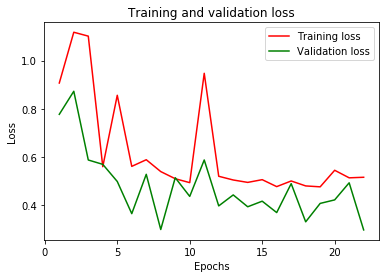

In [28]:
# Plot of Training vs Validation Loss
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'loss', 'accuracy', 'precision_1', 'recall_1'])


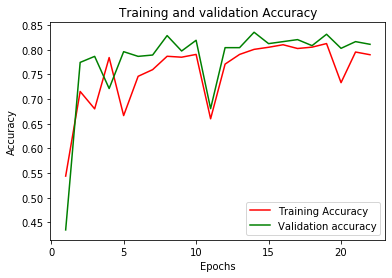

In [29]:
# Plot of Training vs Validation Accuracy
hist_dict = history.history
print(history_dict.keys())
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'g', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h4>Calculation of metrics</h3>

In [35]:
print('Accuracy: {:0.3f}'.format(evaluate [1]))

Accuracy: 0.822


In [36]:
print('Precision: {:0.3f}'.format(evaluate [2]))

Precision: 0.844


In [37]:
print('Recall: {:0.3f}'.format(evaluate [3]))

Recall: 0.873
